<a href="https://colab.research.google.com/github/osgeokr/GEE-PAM-Book/blob/main/240625_KARI_SDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 42.8 MB/s eta 0:00:00


In [25]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon
import rasterio
from rasterio.plot import show
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

<ipython-input-6-e7ed24c77dbd>:37: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


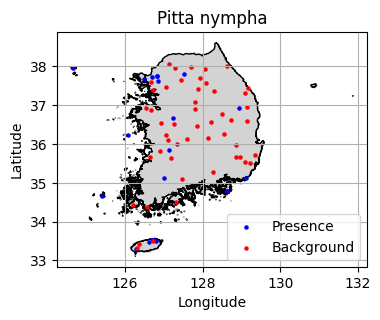

In [6]:
# 출현 좌표 읽기
df = pd.read_csv('https://github.com/osgeokr/GEE-PAM-Book/raw/main/pitta_nympha.csv?raw=True')

# DataFrame을 GeoDataFrame으로 변환
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.decimalLongitude, df.decimalLatitude))

# 한국 경계
kor_gdf = gpd.read_file('https://github.com/osgeokr/GEE-PAM-Book/raw/main/kor.gpkg?raw=True')

# 폴리곤 내부에서 임의 좌표 생성
num_points = len(gdf) * 2 # 좌표 개수 정의
polygon = kor_gdf.unary_union  # 단일 폴리곤으로 결합

points = []
while len(points) < num_points:
    minx, miny, maxx, maxy = polygon.bounds
    random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
    if polygon.contains(random_point):
        points.append(random_point)

rand_gdf = gpd.GeoDataFrame(geometry=points)

# GeoDataFrame 플롯
fig, ax = plt.subplots(figsize=(4, 4))

# Plot the South Korea GeoDataFrame
kor_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', label='South Korea')
gdf.plot(ax=ax, marker='o', color='blue', markersize=5, label='Presence')
rand_gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Background')

plt.legend()
plt.title('Pitta nympha')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

# Show the plot
plt.show()

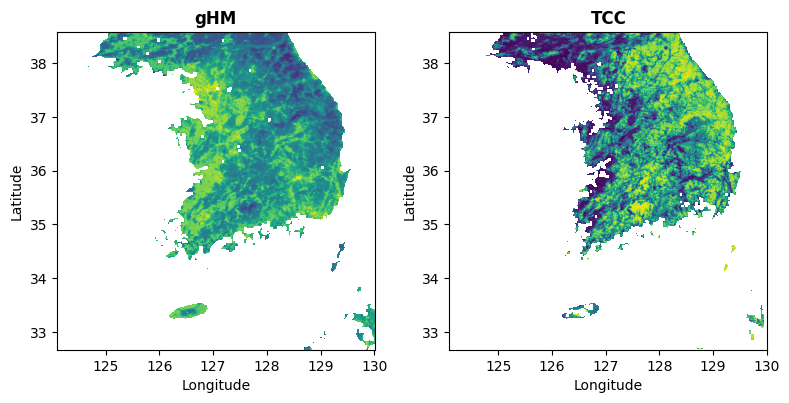

In [21]:
# gHM와 TCC 래스터 호출
ghm_file = 'https://github.com/osgeokr/GEE-PAM-Book/blob/main/ghm.tif?raw=True'
ghm = rasterio.open(ghm_file)

tcc_file = 'https://github.com/osgeokr/GEE-PAM-Book/blob/main/tcc.tif?raw=True'
tcc = rasterio.open(tcc_file)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# gHM 플롯
show(ghm, ax=ax1, title='gHM')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# TCC 플롯
show(tcc, ax=ax2, title='TCC')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

In [30]:
# 통합 데이터 생성 및 presence 필드 추가
gdf['presence'] = 1
rand_gdf['presence'] = 0
combined_gdf = pd.concat([gdf, rand_gdf])

# 좌표에 대한 픽셀 값을 샘플링하여 새 필드 추가
def sample_raster(raster, points_gdf):
    values = []
    for geom in points_gdf.geometry:
        if geom.geom_type == 'Point':
            point = geom
            try:
                for val in raster.sample([(point.x, point.y)]):
                    values.append(val[0])
            except ValueError:
                values.append(None)
        else:
            values.append(None)
    return values

combined_gdf['ghm_value'] = sample_raster(ghm, combined_gdf)
combined_gdf['tcc_value'] = sample_raster(tcc, combined_gdf)

# ghm_value나 tcc_value가 없는 경우 해당 좌표를 삭제
combined_gdf = combined_gdf.dropna(subset=['ghm_value', 'tcc_value'])
combined_gdf.head(1)

,decimalLatitude,decimalLongitude,species,geometry,presence,ghm_value,tcc_value
0,33.516865,126.7171,Pitta nympha,POINT (126.71710 33.51687),1,0.612164,61.037022


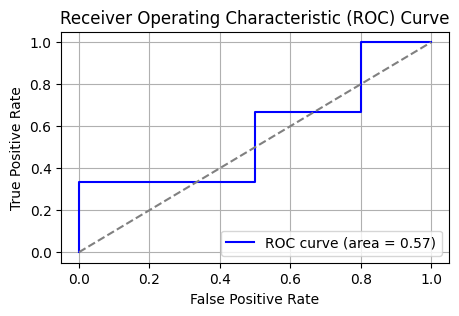

In [37]:
# 학습 데이터와 검증 데이터 분할 (7:3 비율)
train_gdf = combined_gdf.groupby('presence', group_keys=False).apply(lambda x: x.sample(frac=0.7))
test_gdf = combined_gdf.drop(train_gdf.index)

# 특징 변수와 라벨 준비
X_train = train_gdf[['ghm_value', 'tcc_value']]
y_train = train_gdf['presence']
X_test = test_gdf[['ghm_value', 'tcc_value']]
y_test = test_gdf['presence']

# Logistic Regression 모델 학습
model = LogisticRegression()
model.fit(X_train, y_train)

# 예측 및 ROC 커브 그리기
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


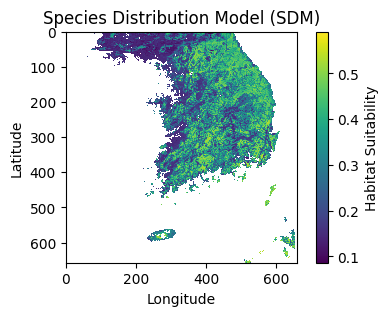

In [41]:
# SDM 지도 래스터 생성
ghm_array = ghm.read(1)
tcc_array = tcc.read(1)

# 두 래스터 배열에서 값이 유효한 위치를 선택하여 모델 예측 수행
valid_mask = ~np.isnan(ghm_array) & ~np.isnan(tcc_array)
ghm_valid = ghm_array[valid_mask]
tcc_valid = tcc_array[valid_mask]

# 모델 예측 수행
X_valid = np.column_stack((ghm_valid, tcc_valid))
sdm_valid = model.predict_proba(X_valid)[:, 1]

# 예측 결과를 원래 배열 형태로 복원
sdm_map = np.full(ghm_array.shape, np.nan)
sdm_map[valid_mask] = sdm_valid

# SDM 지도 시각화
plt.figure(figsize=(5, 3))
plt.imshow(sdm_map, cmap='viridis', interpolation='none')
plt.colorbar(label='Habitat Suitability')
plt.title('Species Distribution Model (SDM)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()